In [76]:
from modeling import *
from som import SOM
from sklearn.preprocessing import MinMaxScaler

In [77]:
df = read_csv('features-BIDU-5y.csv')
df = prepare_df(df)

# dropping columns for training
df_prepared = df.drop(columns=[' High', ' Low', 'profit', 'close_plus_20_days', 'Date'])
# df_prepared = pd.DataFrame()
# df_prepared['profit'] = df['profit']
# df_prepared['profit1'] = df['profit']
# df_prepared['profit2'] = df['profit']
# df_prepared['profit3'] = df['profit']

df_train_columns = df_prepared.columns
df_prepared = np.array(df_prepared)

# scaling data
scaler = MinMaxScaler()
df_prepared = scaler.fit_transform(df_prepared)

#splitting dataset into training and testing
train_len = len(df_prepared)-365
df_train = df_prepared[:train_len]
df_test = df_prepared[train_len:]


Tak jak pisał w artykule, niektóre zmienne mogą być skorelowane i warto byłoby coś z tym zrobił. On tam proponował usunąć te skorelowane, ale ja po prostu robie pca dzięki czemu też pozbywam się korelacji

In [78]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [63]:
variance_inflation_factors(pd.DataFrame(df_prepared))

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


const     0.000000
0         1.089926
1              inf
2              inf
3              inf
4         3.259381
5              inf
6              inf
7        23.218845
8         2.930817
9        31.652664
10             inf
11             inf
12       14.825226
13        2.950047
14       68.283561
15        6.050525
16        7.605981
Name: VIF, dtype: float64

In [79]:
# df_prepared = pd.DataFrame(df_prepared)[[0,4,8,2,15]]
# df_prepared = pd.DataFrame(df_prepared)[[0,4]]

df_prepared = pd.DataFrame(df_prepared)[list(range(13))]

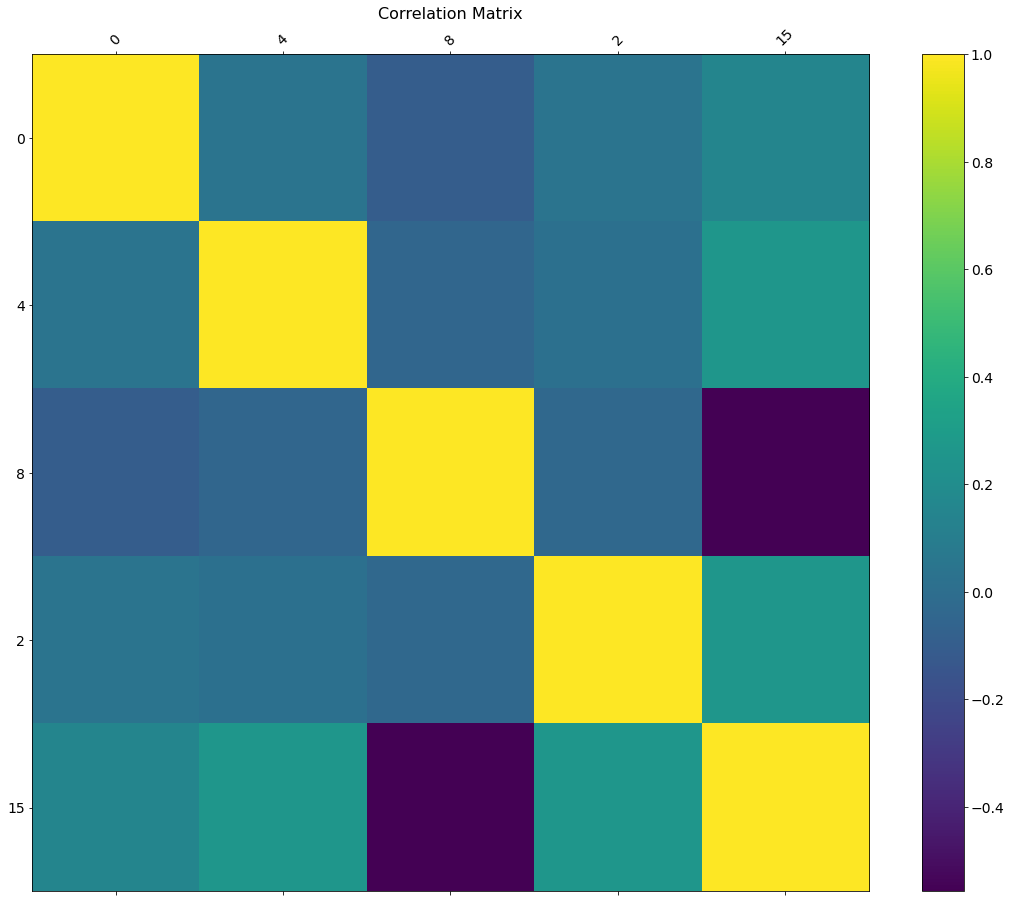

In [151]:
plot_corelation_matrix(df_prepared)

In [8]:
from sklearn.decomposition import PCA

# decreasing amount of column to 90% of initial amount
pca = PCA(n_components=(int(df_prepared.shape[1]*0.9)))
df_prepared = pca.fit_transform(df_prepared)

plot_corelation_matrix(df_prepared)

Fajnym sposobem oceniania jakości algorytmu będzie podpisanie każdego kafelka mapy gęstości odpowiednią wartością zwrotu.

Chyba źle robie wyznaczanie ktore clustry sa buy, sell i keep, powinienem raczej patrzyć po distance map.

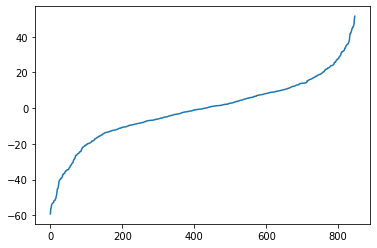

In [131]:
plt.plot(pd.DataFrame(df_train)[0].sort_values().reset_index(drop=True))

In [80]:
lower_limit = round(len(y) / 3)
upper_limit = round(len(y) / 3 * 2)

lower_limit = y.sort_values(by='profit').reset_index().iloc[lower_limit]['profit']
upper_limit = y.sort_values(by='profit').reset_index().iloc[upper_limit]['profit']
lower_limit,upper_limit

(-6.77000000000001, 6.409999999999997)

In [81]:
def get_class(x, lower_limit, upper_limit):
    if x < lower_limit:
        return 0 # sell
    if x >= lower_limit and x < upper_limit:
        return 1 #keep
    if x>= upper_limit:
        return 2 #buy
y = pd.DataFrame()
y['profit'] = df['profit']
y = y[:train_len]
df_train_y = np.array(pd.DataFrame(y)['profit'].apply(lambda x: get_class(x, lower_limit, upper_limit)))
label_names = {0:'sell', 1:'keep', 2:'buy'}


In [5]:
# import pandas as pd
# import numpy as np

# df_train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
#                     names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
#                    'asymmetry_coefficient', 'length_kernel_groove', 'target'], 
#                    sep='\t+', engine='python')
# df_train_y = df_train['target'].values
# label_names = {1:'Kama', 2:'Rosa', 3:'Canadian'}
# df_train = df_train[df_train.columns[:-1]]
# # data normalization
# df_train = (df_train - np.mean(df_train, axis=0)) / np.std(df_train, axis=0)
# df_train = df_train.values

In [82]:
lr = 0.1
sigma = 1.5
seed = 0
neighborhood_function='gaussian' #gaussian, mexican_hat, bubble, triangle
n_iter = 1000

In [83]:
from minisom import MiniSom
som_shape = (9,9)
som = MiniSom(som_shape[0], som_shape[1], df_train.shape[1],sigma=sigma, learning_rate=lr, 
              neighborhood_function=neighborhood_function, random_seed=seed)
som.train(df_train, n_iter) # trains the SOM with 100 iterations

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in df_train]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

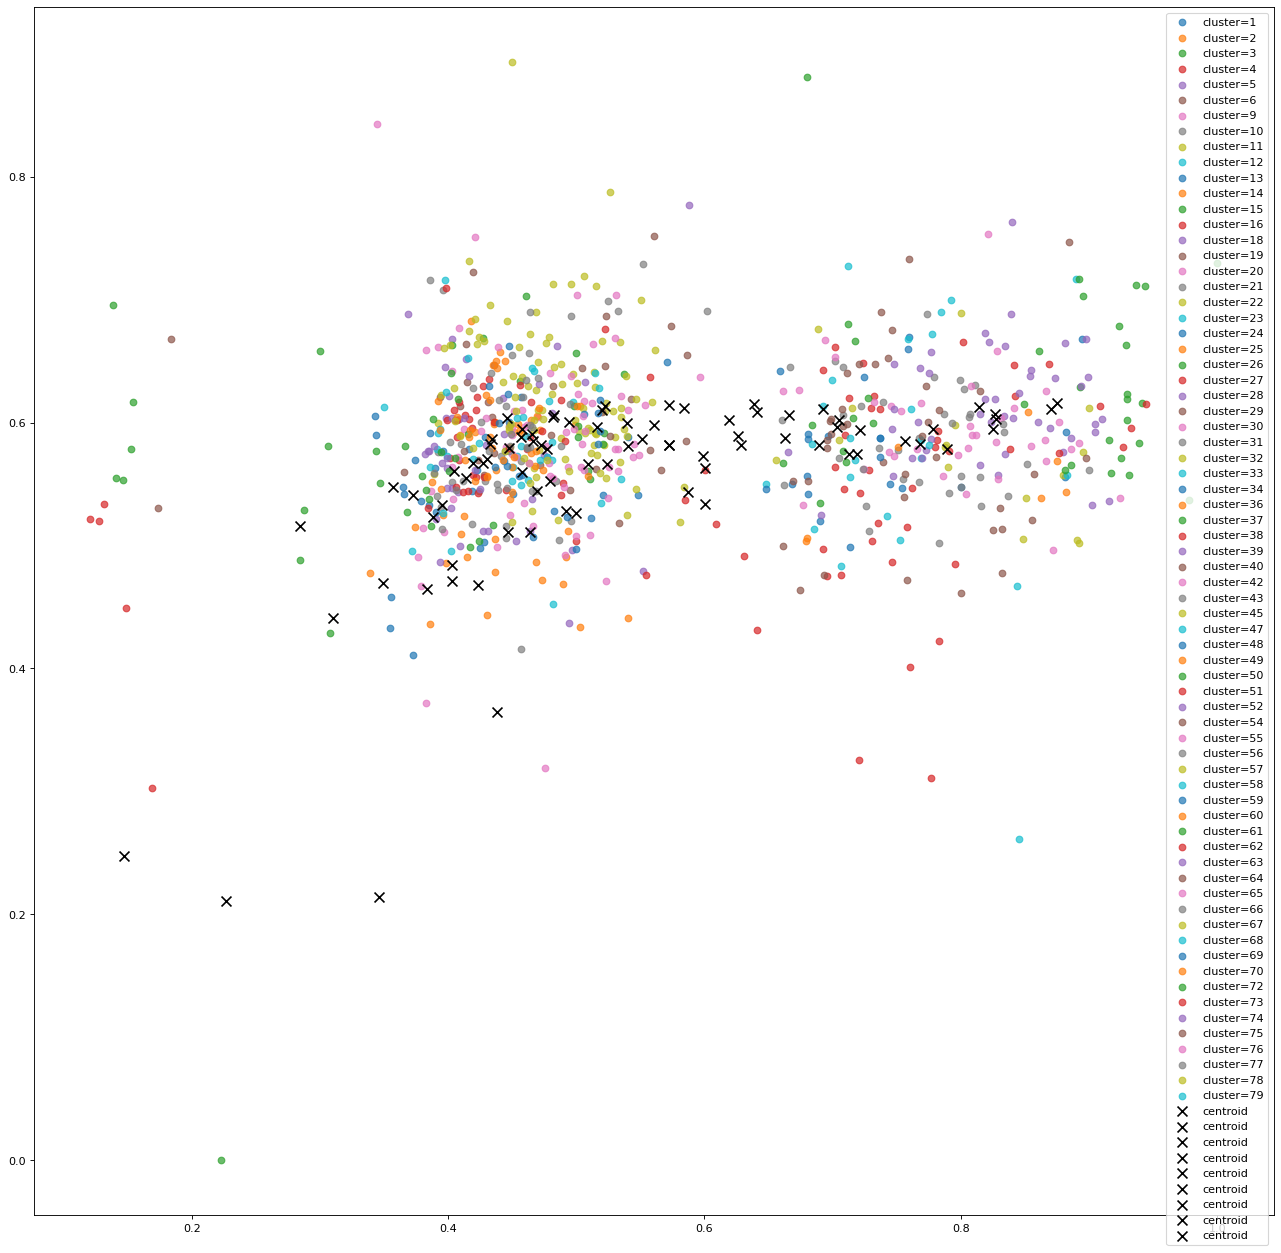

In [69]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# from matplotlib.pyplot import figure
# figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

# # plotting the clusters using the first 2 dimentions of the data
# for c in np.unique(cluster_index):
#     plt.scatter(df_train[cluster_index == c, 0],
#                 df_train[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# # plotting centroids
# for centroid in som.get_weights():
#     plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
#                 s=80, linewidths=35, color='k', label='centroid')
# plt.legend();

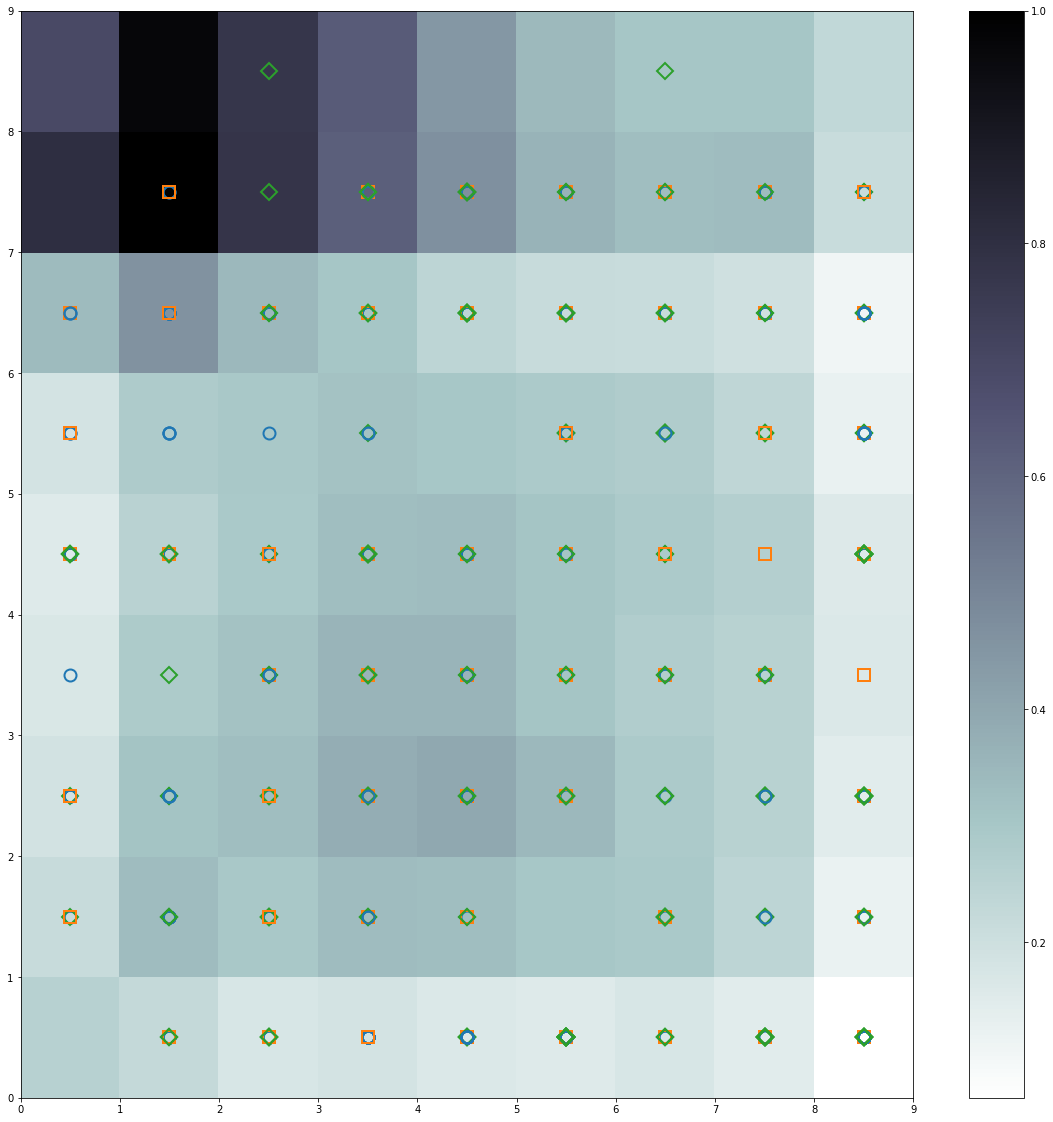

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(df_train):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[df_train_y[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[df_train_y[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

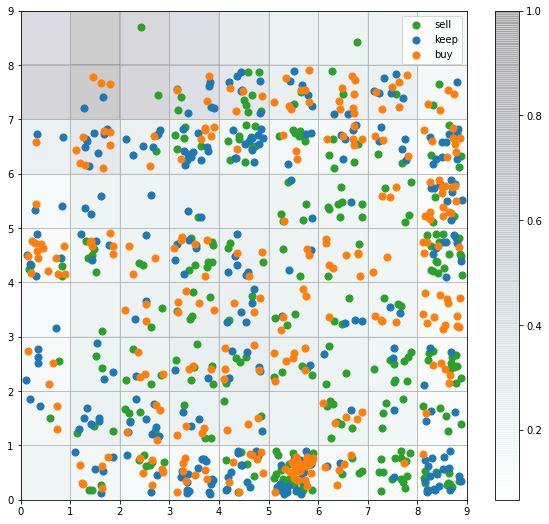

In [85]:
target = df_train_y
w_x, w_y = zip(*[som.winner(d) for d in df_train])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])

plt.legend(loc='upper right')
plt.grid()
plt.show()

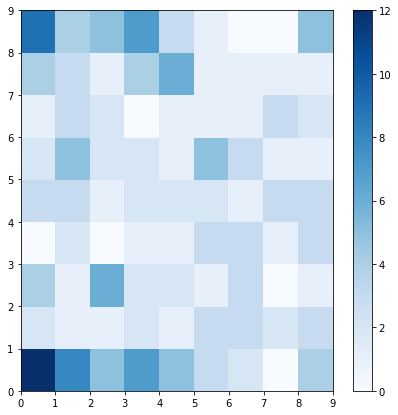

In [34]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(df_train)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

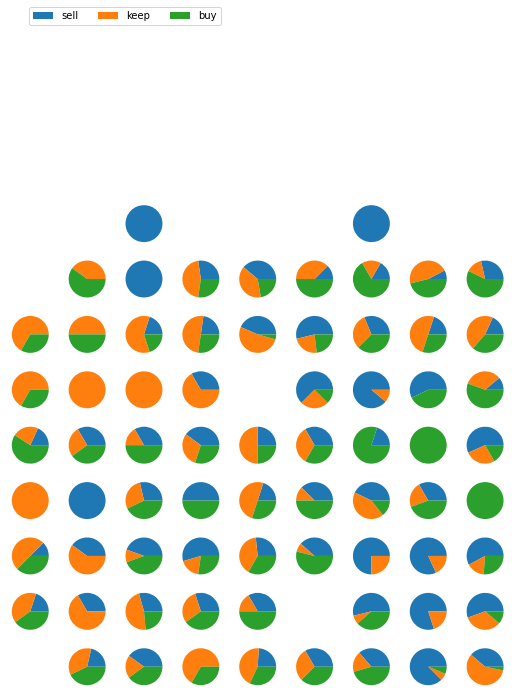

In [86]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(df_train, [label_names[t] for t in df_train_y])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(som_shape[0], som_shape[1], fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[som_shape[0]-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.show()

/home/dawid/mckinsey/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


Error history plot done!


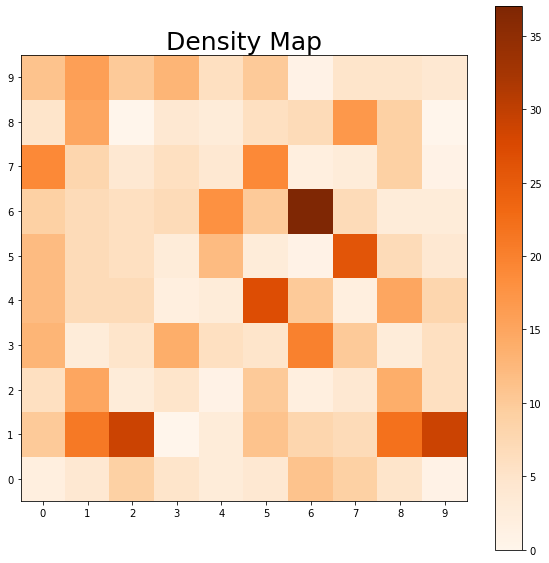

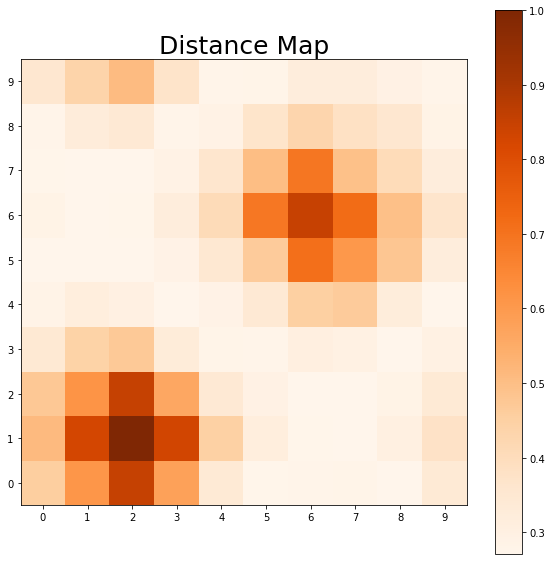

/home/dawid/mckinsey/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2265: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if v not in values:


ValueError: array([[-6.52, -6.52, -6.52, -6.52],
       [-4.33, -4.33, -4.33, -4.33],
       [-0.05, -0.05, -0.05, -0.05],
       ...,
       [10.23, 10.23, 10.23, 10.23],
       [ 7.92,  7.92,  7.92,  7.92],
       [ 9.42,  9.42,  9.42,  9.42]]) is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

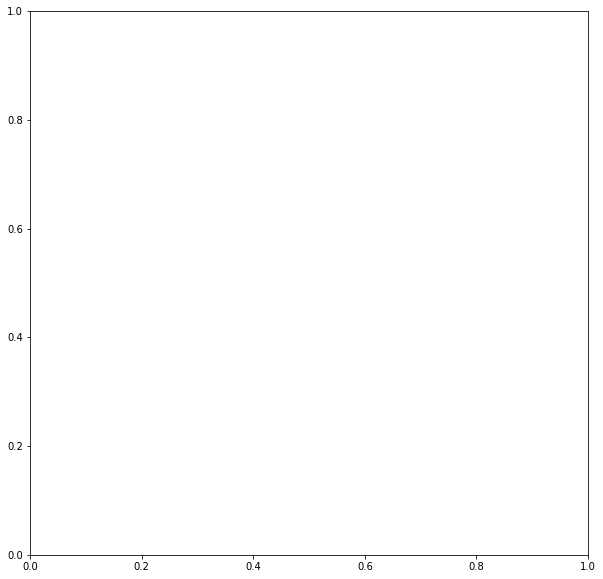

In [133]:
df = read_csv('features-BIDU-5y.csv')
df = prepare_df(df)

# dropping columns for training
# df_prepared = df.drop(columns=[' High', ' Low', 'profit', 'close_plus_20_days', 'Date'])
df_prepared = pd.DataFrame()
df_prepared['profit'] = df['profit']
df_prepared['profit1'] = df['profit']
df_prepared['profit2'] = df['profit']
df_prepared['profit3'] = df['profit']

df_train_columns = df_prepared.columns
df_prepared = np.array(df_prepared)

# scaling data
scaler = MinMaxScaler()
# df_prepared = scaler.fit_transform(df_prepared)

#splitting dataset into training and testing
train_len = len(df_prepared)-365
df_train = df_prepared[:train_len]
df_test = df_prepared[train_len:]



# fitting the model
map_width = 10
map_height = 10
som = SOM(map_width, map_height, seed=0)  
som.fit(df_train, 10000, save_e=True, interval=100, decay='linear')
som.plot_error_history(filename='../images/som_error.png')

# plotting density and distance map
som.plot_density_map(df_train)
som.plot_distance_map()

# converting numpy arrays to dataframes
df_train = pd.DataFrame(df_train, columns=df_train_columns)
df_test = pd.DataFrame(df_test, columns=df_train_columns)

# creating column with cluster basing on model prediction
df_train['cluster'] = df_train.apply(lambda x: som_predict(x, som), axis=1)
df_test['cluster'] = df_test.apply(lambda x: som_predict(x, som), axis=1)

# joining train and test dataframes with previously dropped columns, which will be useful in the further part of the script
final_df_train = df_train.join(df[['Date','Price','close_plus_20_days','profit']].iloc[:, :train_len], lsuffix='_org')
final_df_test = df_test.join(df[['Date','Price','close_plus_20_days','profit']].iloc[train_len:].reset_index(drop=True), lsuffix='_org')

# callculating mean profit per custer
profit_per_cluster = pd.DataFrame(final_df_train.groupby(by='cluster')['profit'].mean(), columns=['profit']).reset_index()

In [105]:
def add_missing_clusters(map_width, map_height, profit_per_cluster):
    """
    Add missing cluster to the results list. 
    The default cluster profit is 0.
    """
    n_clusters = map_width * map_height
    for i in range(n_clusters):
        # if there is a missing cluster add a new empty one
        if i not in list(profit_per_cluster.cluster):
            new_row = pd.DataFrame({"cluster":i, "profit":-123}, index=[len(profit_per_cluster)])
            profit_per_cluster = pd.concat([profit_per_cluster, new_row])
    return profit_per_cluster

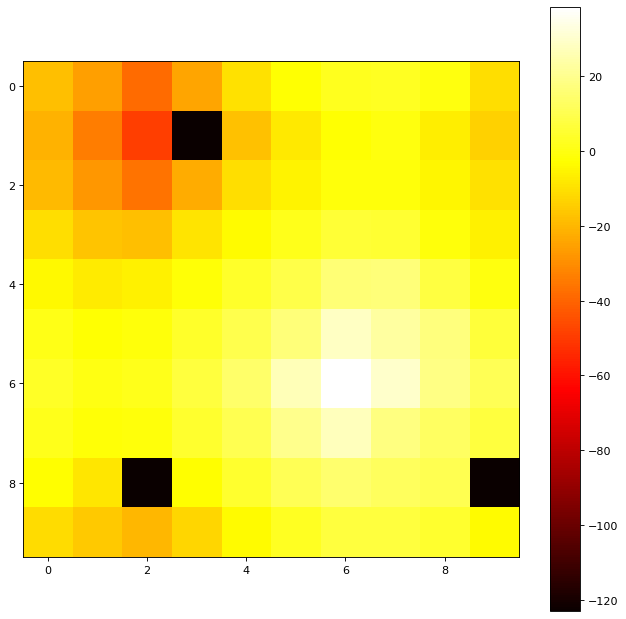

In [124]:
profit_per_cluster = add_missing_clusters(map_width, map_height, profit_per_cluster)
profit_per_cluster_map = np.array(profit_per_cluster.sort_values(by='cluster')['profit']).reshape(map_width,map_height)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

heatmap = plt.imshow(profit_per_cluster_map, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)
plt.show()

**Notatka**

*Myślę, że warto będzie jeśli przeczytasz sobie czym jest density i dsitance map w sieciach kohonena i jakoś skomentujesz to wynika z tych zdjęć.*

In [ ]:
plot_avg_cluster_profit(final_df_train)

Basing on the average return of each cluster we are trying to find best cutoffs points, after which the cluster will be labeled as buy, sell and hold.

**Notatka**

*W przypadku bidu zdecydowałem się ustawić punkty odcięcia na -10 i 10. Dzięki temu sprzedajemy tylko w clustrach z średnim niskim profitem, trzymamy tam gdzie nie jest jakoś bardzo skrajny, a sprzedajemy tam gdzie jest duży. W przypadku, w którym dolny cutoff przesunęlibyśmy zbyt nisko, a górny zbyt wysoko, istnieje szansa, że po zaaplikowaniu predykcji na zbiorze testowym (czyli najnowszych danych) żadne próbki nie zostałyby oznaczone jako kup lub sprzedaj. Moglibyśmy też próbować postawić tylko jedną granicę (na 0) i wtedy to co powyżej to sprzedajemy, a to co poniżej to sprzedajemy, ale w praktyce, gdgbyśmy zaaplikowali coś takiego do danych testowych, najprawdopodobniej okazałoby się, że grupy te nie są od siebie dostatecznie różne i albo byśmy nie zarabiali albo tracili*

In [109]:
lower_cutoff = -10
higher_cutoff = 10

buy_cluster = list(profit_per_cluster.loc[profit_per_cluster['profit']>higher_cutoff]['cluster'])
sell_cluster = list(profit_per_cluster.loc[profit_per_cluster['profit']<lower_cutoff]['cluster'])
hold_cluster = list(profit_per_cluster.loc[(profit_per_cluster['profit']<=higher_cutoff) & (profit_per_cluster['profit']>=lower_cutoff)]['cluster'])

In [110]:
# callculating mean profit for each cluster on training and testing dataset
buy_clusters_train_mean_profit = final_df_train.loc[final_df_train['cluster'].isin(buy_cluster)]['profit'].mean()
print(f'buy_clusters_train_mean_profit: {buy_clusters_train_mean_profit}')
buy_clusters_test_mean_profit = final_df_test.loc[final_df_test['cluster'].isin(buy_cluster)]['profit'].mean()
print(f'buy_clusters_test_mean_profit: {buy_clusters_test_mean_profit}\n')

hold_clusters_train_mean_profit = final_df_train.loc[final_df_train['cluster'].isin(hold_cluster)]['profit'].mean()
print(f'hold_clusters_train_mean_profit: {hold_clusters_train_mean_profit}')
hold_clusters_test_mean_profit = final_df_test.loc[final_df_test['cluster'].isin(hold_cluster)]['profit'].mean()
print(f'hold_clusters_test_mean_profit: {hold_clusters_test_mean_profit}\n')

sell_clusters_train_mean_profit = final_df_train.loc[final_df_train['cluster'].isin(sell_cluster)]['profit'].mean()
print(f'sell_clusters_train_mean_profit: {sell_clusters_train_mean_profit}')
sell_clusters_test_mean_profit = final_df_test.loc[final_df_test['cluster'].isin(sell_cluster)]['profit'].mean()
print(f'sell_clusters_test_mean_profit: {sell_clusters_test_mean_profit}')

buy_clusters_train_mean_profit: 18.784513274336287
buy_clusters_test_mean_profit: 8.139846153846156

hold_clusters_train_mean_profit: -0.02888601036269461
hold_clusters_test_mean_profit: 3.5539495798319334

sell_clusters_train_mean_profit: -21.47731914893617
sell_clusters_test_mean_profit: -2.162099447513813


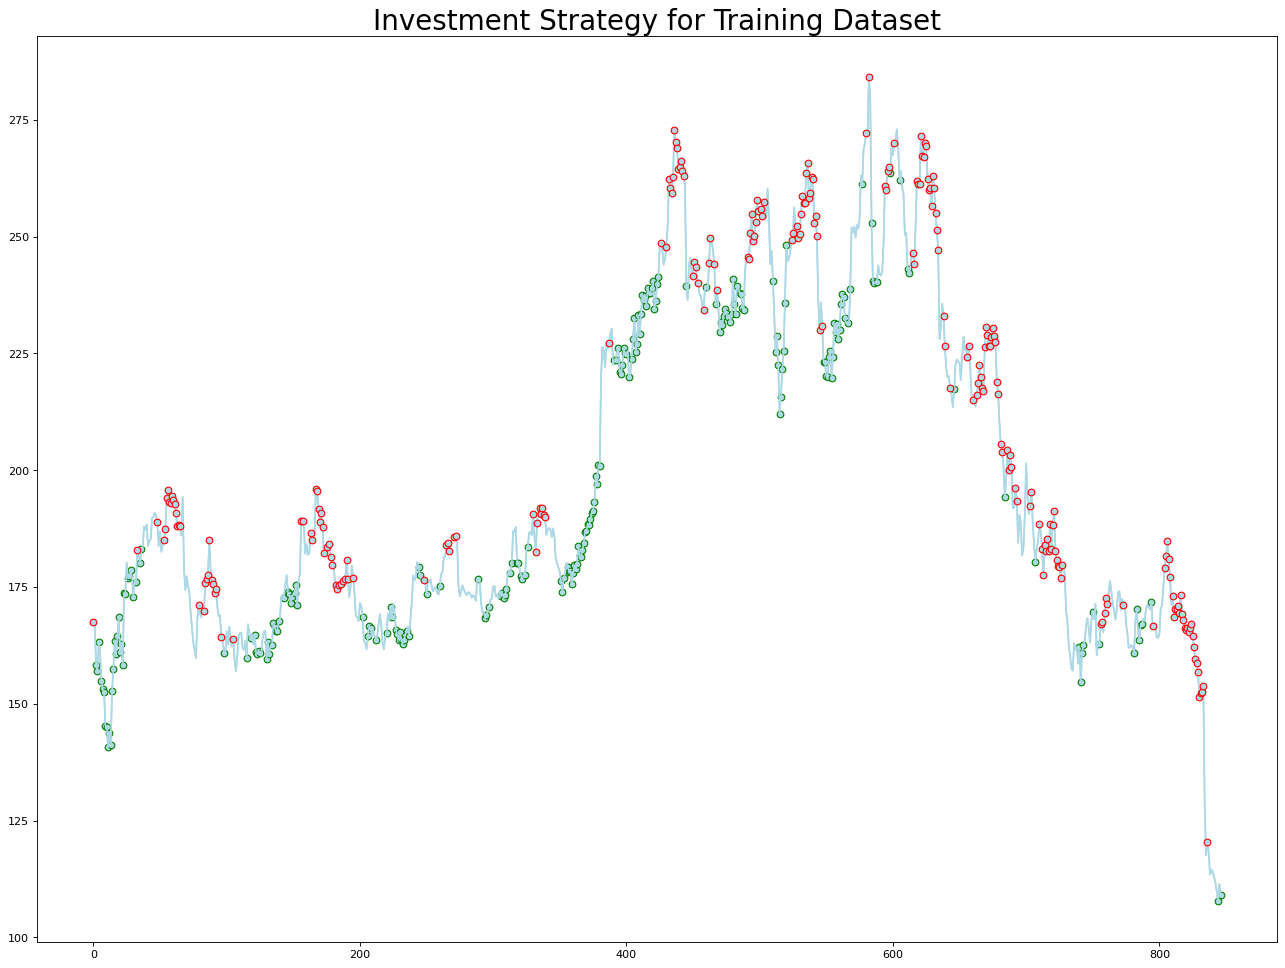

In [111]:
plot_strategy(final_df_train,'Training',buy_cluster, sell_cluster )

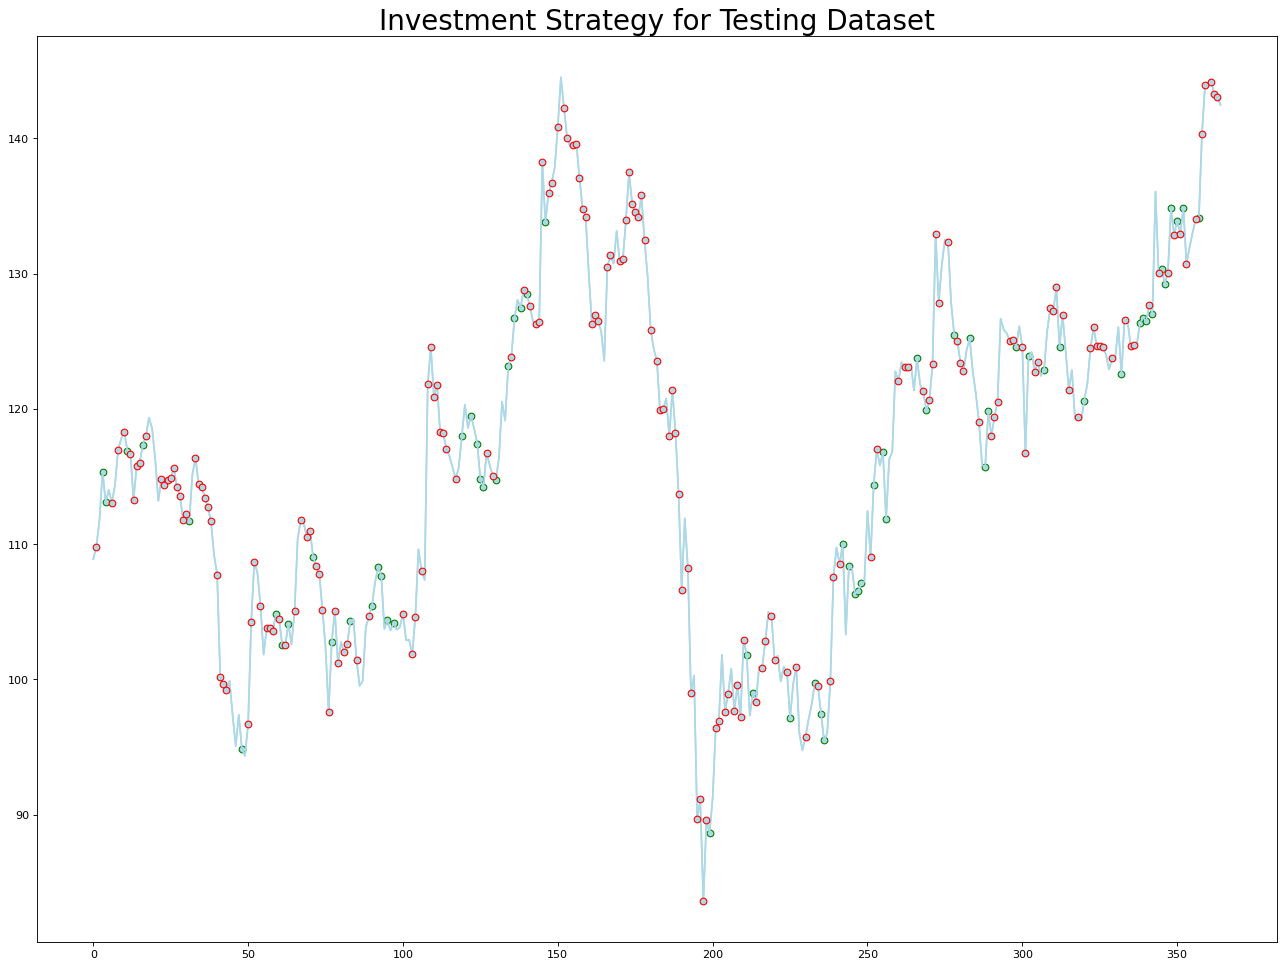

In [112]:
plot_strategy(final_df_test,'Testing',buy_cluster, sell_cluster )

**Notatka**

*profit to (wartość akcji w t+20) - (wartość akcji w t)*
*tak więc dla danych treningowych clustry są wyznaczone sensownie, ale to nic dziwnego, bo dzieliliśmy je w taki sposób, aby dla danych z etykieta sell profit był znacząco mniejszy od 0, dla danych z etykietą keep bliski 0, a dla danych z etykietą sell jak najwyższy*

*W przypadku danych testowych nie jest już tak kolorowo. Co prawda profit dla danych z etykietą sell jest cały czas mniejszy od 0, co nas cieszy (bo cena po 20 dniach jest niższa niż była zanim sprzedaliśmy), ale dla danych z etykietą buy profit też jest mniejszy od 0, co znaczy, że robimy to w złym momencie (bo kupujemy drożej niż sprzedajemy) *

*Mimo wszystko zakładając, że ilość transakcji sell jest więcej niż buy, bylibyśmy w stanie zarabiać na takiej taktyce*